In [6]:
# retrieve the ISIC dataset stuff
!wget https://isic-challenge-data.s3.amazonaws.com/2024/ISIC_2024_Training_Input.zip
!unzip ISIC_2024_Training_Input.zip

!wget https://isic-challenge-data.s3.amazonaws.com/2024/ISIC_2024_Training_Supplement.csv
!wget https://isic-challenge-data.s3.amazonaws.com/2024/ISIC_2024_Training_GroundTruth.csv

Der Befehl "wget" ist entweder falsch geschrieben oder
konnte nicht gefunden werden.
Der Befehl "unzip" ist entweder falsch geschrieben oder
konnte nicht gefunden werden.
Der Befehl "wget" ist entweder falsch geschrieben oder
konnte nicht gefunden werden.
Der Befehl "wget" ist entweder falsch geschrieben oder
konnte nicht gefunden werden.


In [1]:
# params
FREEZE = True # whether or not to freeze the weights
EPOCHS = 5 # number of training epochs
DUPE = True

In [2]:
# setup the model to be transfer learned
import torch
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision import datasets
from sklearn.model_selection import train_test_split


In [ ]:
transform = transforms.Compose([
    transforms.ToTensor()
])

class CustomImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = [os.path.join(root_dir, fname) for fname in os.listdir(root_dir) if fname.endswith(('png', 'jpg', 'jpeg'))]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image

# Define a transform to convert images to tensors
transform = transforms.Compose([
    transforms.ToTensor()
])

# Load the dataset
dataset = CustomImageDataset(root_dir='./ISIC_2024_Training_Input/', transform=transform)
loader = DataLoader(dataset, batch_size=64, shuffle=False, num_workers=4)

# Calculate mean and standard deviation
mean = 0.0
std = 0.0
nb_samples = 0

for data in loader:
    batch_samples = data.size(0)
    data = data.view(batch_samples, data.size(1), -1)
    mean += data.mean(2).sum(0)
    std += data.std(2).sum(0)
    nb_samples += batch_samples

mean /= nb_samples
std /= nb_samples

# Print the calculated mean and standard deviation
print(f'Mean: {mean}')
print(f'Std: {std}')

In [3]:

df = pd.read_csv('ISIC_2024_Training_GroundTruth.csv')
print(f"num malignant: {sum(df['malignant'])}")

# downsample for time
df = df.sample(frac=.2, random_state=42)

train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['malignant'], random_state=42)

if DUPE:
    malig_df = train_df[train_df['malignant'] == 1]
    malig_df = pd.concat([malig_df]*100, ignore_index=True)

    train_df = pd.concat([train_df, malig_df], ignore_index=True)

    #malig_df = val_df[val_df['malignant'] == 1]
    #malig_df = pd.concat([malig_df]*100, ignore_index=True)

    #val_df = pd.concat([val_df, malig_df], ignore_index=True)

train_df.to_csv('train_labels.csv', index=False)
val_df.to_csv('val_labels.csv', index=False)

print(f"Validation - Num malignant: {val_df['malignant'].sum()}")
print(f"Validation - Num benign: {len(val_df) - val_df['malignant'].sum()}")
print(f"Training - Num malignant: {train_df['malignant'].sum()}")
print(f"Training - Num benign: {len(train_df) - train_df['malignant'].sum()}")

class ISICDataset(Dataset):
    def __init__(self, csv_file, img_dir, non_malignant_transform=None, malignant_transform=None):
        self.df = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.non_malignant_transform = non_malignant_transform
        self.malignant_transform = malignant_transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.df.iloc[idx, 0] + '.jpg')

        image = Image.open(img_path).convert('RGB')

        if self.df.iloc[idx, 1] == 0 and self.non_malignant_transform:
            image = self.non_malignant_transform(image)
        elif self.df.iloc[idx, 1] == 1 and self.malignant_transform:
            image = self.malignant_transform(image)

        return image, int(self.df.iloc[idx, 1]), self.df.iloc[idx, 0]



transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # ImageNet means
                         std=[0.229, 0.224, 0.225])    # ImageNet stds
])

malignant_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    #transforms.RandomRotation(degrees=30),
    #transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    #transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_dataset = ISICDataset(
    csv_file='val_labels.csv',
    img_dir='./ISIC_2024_Training_Input/',
    non_malignant_transform=transform,
    malignant_transform=transform
)

train_dataset = ISICDataset(
    csv_file='train_labels.csv',
    img_dir='./ISIC_2024_Training_Input/',
    non_malignant_transform=transform,
    malignant_transform=malignant_transform
)

dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valloader = DataLoader(val_dataset, batch_size=32, shuffle=True)

print(f"Training set size: {len(dataloader.dataset)}")
print(f"Validation set size: {len(valloader.dataset)}")
#malig = sum([x[1] for x in dataloader.dataset])


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Training on {'cuda' if torch.cuda.is_available() else 'cpu'}")


num malignant: 393.0
Validation - Num malignant: 15.0
Validation - Num benign: 16028.0
Training - Num malignant: 5959.0
Training - Num benign: 64110.0
Training set size: 70069
Validation set size: 16043
Training on cuda


In [13]:
import time
from sklearn.metrics import roc_auc_score

resnet = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)

if FREEZE:
  for param in resnet.parameters():
    param.requires_grad = False

# set to 1 for now (either malignant or not, can change based on metadata later)
resnet.fc = nn.Linear(resnet.fc.in_features, 1)


optimizer = optim.Adam(filter(lambda p: p.requires_grad, resnet.parameters()), lr=1e-4)

#criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([(len(dataloader.dataset) - malig)/malig]).to(device))
criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([100.0]).to(device))

# switch to this if we're doing more than malignant/not-malignant
#criterion = nn.CrossEntropyLoss()

resnet.to(device)

start_time = time.time()
for epoch in range(EPOCHS):
    resnet.train()
    avgloss = 0.0
    print(f"EPOCH: {epoch + 1}")
    for images, labels, _ in dataloader:
        images, labels = images.to(device), labels.float().unsqueeze(1).to(device)

        optimizer.zero_grad()
        outputs = resnet(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        avgloss += loss.item() * images.size(0)
    avgloss /= len(dataloader.dataset)

    resnet.eval()
    val_loss = 0.0
    total = 0
    false_negative = 0
    false_positive = 0
    true_negative = 0
    true_positive = 0
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for images, labels, _ in valloader:
            images, labels = images.to(device), labels.to(device).float().unsqueeze(1)

            outputs = resnet(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)

            preds = torch.sigmoid(outputs)
            preds = (preds > 0.5).float()  # threshold to get 0 or 1
            for p, l in zip(preds, labels):
                if p == 0 and l == 0:
                    true_negative += 1
                elif p == 0 and l == 1:
                    false_negative += 1
                elif p == 1 and l == 0:
                    false_positive += 1
                elif p == 1 and l == 1:
                    true_positive += 1
            total += labels.size(0)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    avg_val_loss = val_loss / len(valloader.dataset)
    print(f"Epoch [{epoch+1}/{EPOCHS}] "
          f"Train Loss: {avgloss:.4f} "
          f"Val Loss: {avg_val_loss:.4f} \n"
          f"Val True Negative: {true_negative} "
          f"Val False Negative: {false_negative}\n"
          f"Val True Positive: {true_positive} "
          f"Val False Positive: {false_positive}\n"
          f" Val Accuracy: {(true_positive+true_negative)/(total):.4f}\n"
          f" Val AUC: {roc_auc_score(all_labels, all_preds):.4f}")
    
print(f"Training time: {time.time() - start_time:.2f}s")

EPOCH: 1
Epoch [1/5] Train Loss: 1.9525 Val Loss: 0.7533 
Val True Negative: 10324 Val False Negative: 9
Val True Positive: 6 Val False Positive: 5704
 Val Accuracy: 0.6439
EPOCH: 2
Epoch [2/5] Train Loss: 0.8955 Val Loss: 0.5580 
Val True Negative: 13030 Val False Negative: 11
Val True Positive: 4 Val False Positive: 2998
 Val Accuracy: 0.8124
EPOCH: 3
Epoch [3/5] Train Loss: 0.6556 Val Loss: 0.5392 
Val True Negative: 13469 Val False Negative: 12
Val True Positive: 3 Val False Positive: 2559
 Val Accuracy: 0.8397
EPOCH: 4
Epoch [4/5] Train Loss: 0.5613 Val Loss: 0.5776 
Val True Negative: 13501 Val False Negative: 12
Val True Positive: 3 Val False Positive: 2527
 Val Accuracy: 0.8417
EPOCH: 5
Epoch [5/5] Train Loss: 0.4971 Val Loss: 0.4702 
Val True Negative: 14337 Val False Negative: 11
Val True Positive: 4 Val False Positive: 1691
 Val Accuracy: 0.8939
Training time: 1378.96s


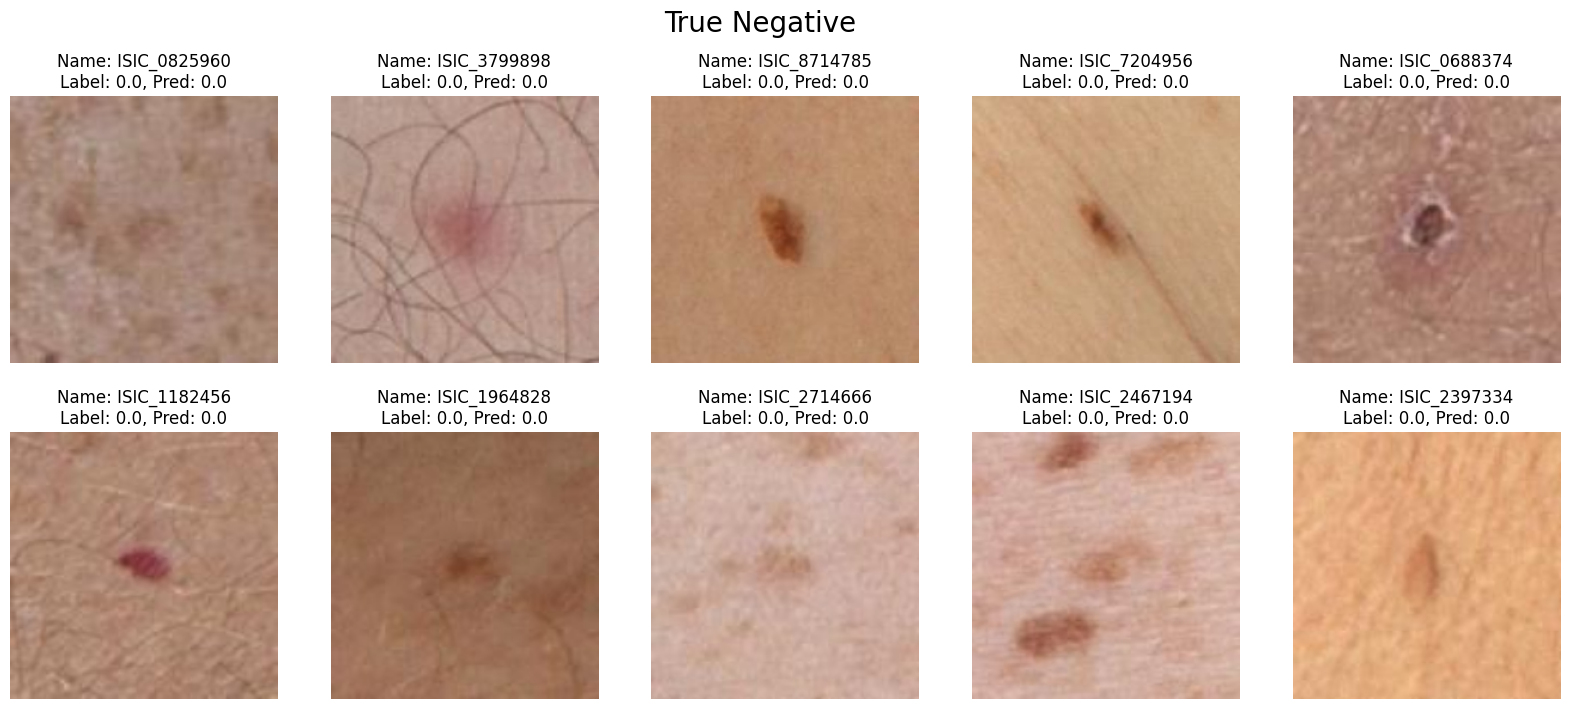

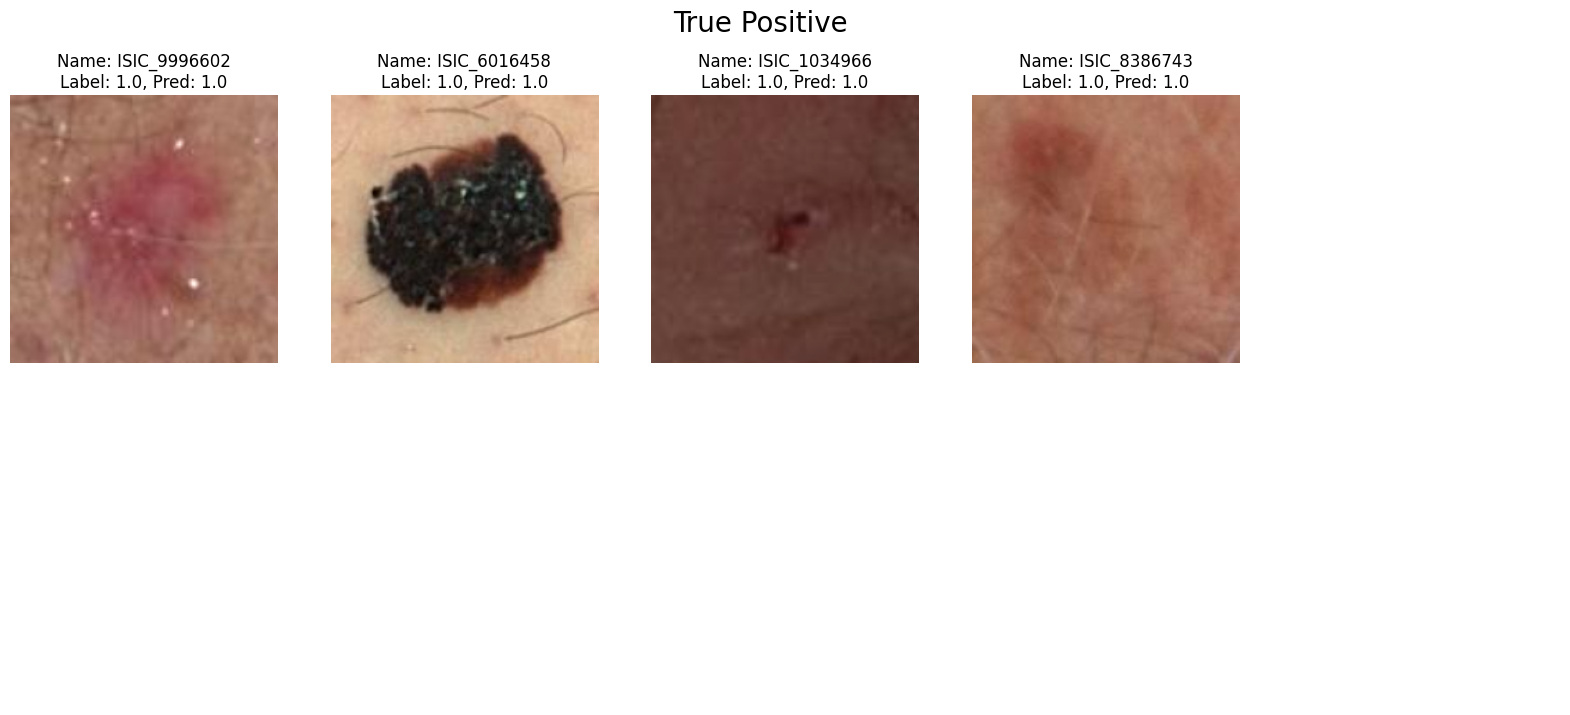

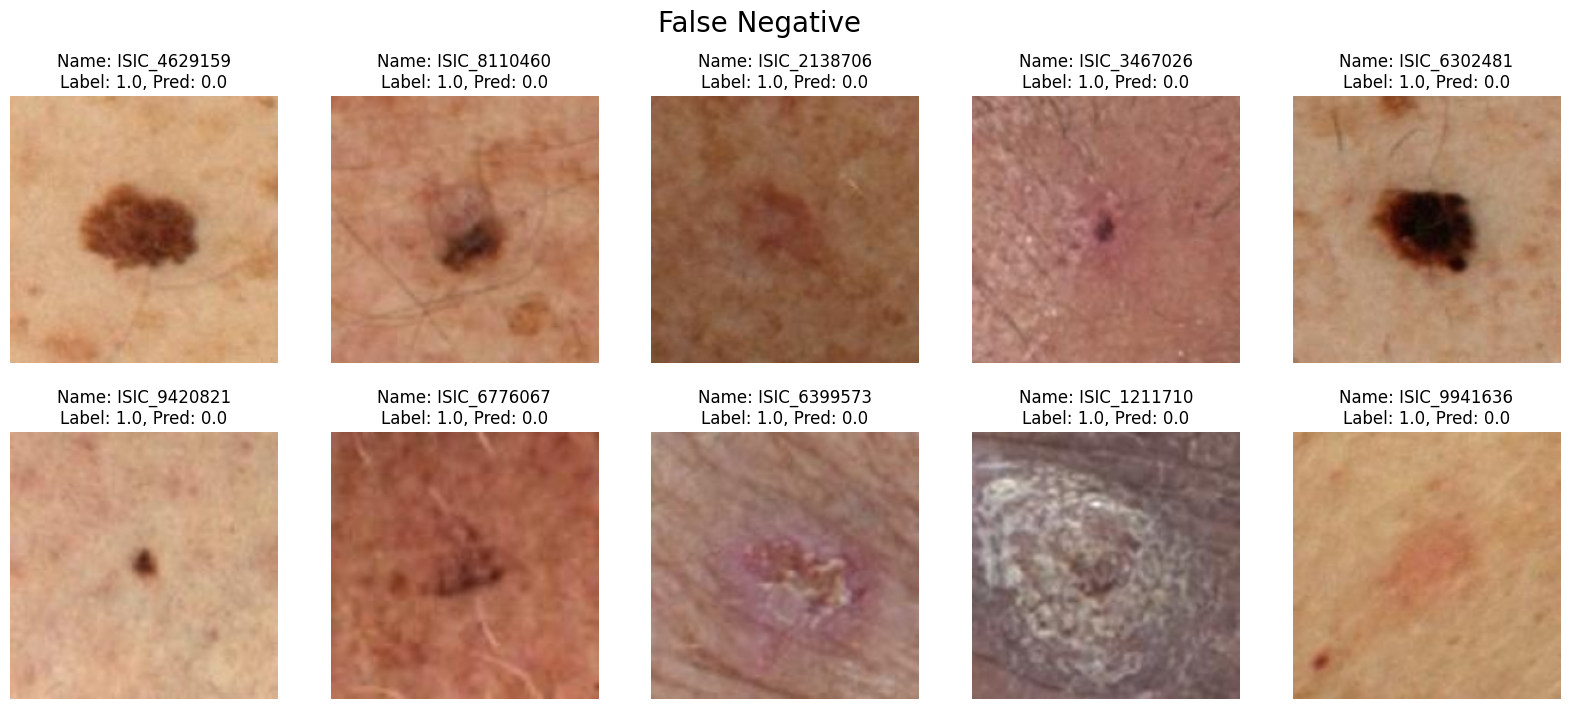

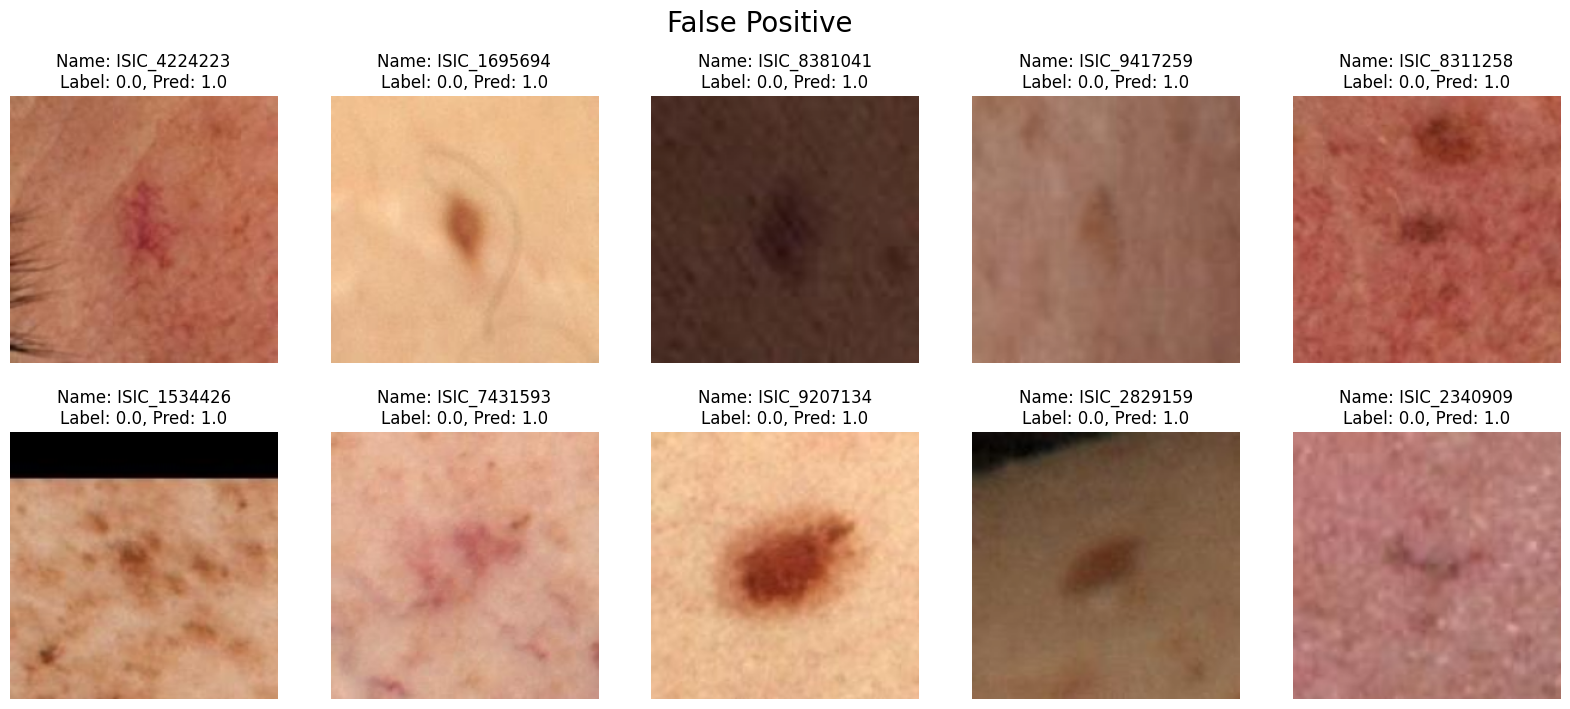

In [14]:
import matplotlib.pyplot as plt
import torch
from torchvision import transforms

# Define the inverse normalization transformation
inv_normalize = transforms.Normalize(
    mean=[-0.485 / 0.229, -0.456 / 0.224, -0.406 / 0.225],
    std=[1 / 0.229, 1 / 0.224, 1 / 0.225]
)

def display_images(images, labels, preds, names, title):
    fig, axes = plt.subplots(2, 5, figsize=(20, 8))
    fig.suptitle(title, fontsize=20)
    for i, (img, label, pred, name) in enumerate(zip(images, labels, preds, names)):
        ax = axes[i // 5, i % 5]
        img = inv_normalize(img)  # Undo normalization
        ax.imshow(img.permute(1, 2, 0).cpu().numpy())
        ax.set_title(f"Name: {name}\nLabel: {label.item()}, Pred: {pred.item()}")
        ax.axis('off')
    # Hide any remaining subplots if there are fewer than 10 images
    for j in range(i + 1, 10):
        axes[j // 5, j % 5].axis('off')
    plt.show()

def get_images_by_type(dataloader, model, device, type, num_images=10):
    images, labels, preds, names = [], [], [], []
    model.eval()
    with torch.no_grad():
        for img_batch, label_batch, name_batch in dataloader:
            img_batch, label_batch = img_batch.to(device), label_batch.to(device).float().unsqueeze(1)
            output_batch = model(img_batch)
            pred_batch = torch.sigmoid(output_batch)
            pred_batch = (pred_batch > 0.5).float()
            for img, label, pred, name in zip(img_batch, label_batch, pred_batch, name_batch):
                if type == 'true_negative' and label == 0 and pred == 0:
                    images.append(img)
                    labels.append(label)
                    preds.append(pred)
                    names.append(name)
                elif type == 'true_positive' and label == 1 and pred == 1:
                    images.append(img)
                    labels.append(label)
                    preds.append(pred)
                    names.append(name)
                elif type == 'false_negative' and label == 1 and pred == 0:
                    images.append(img)
                    labels.append(label)
                    preds.append(pred)
                    names.append(name)
                elif type == 'false_positive' and label == 0 and pred == 1:
                    images.append(img)
                    labels.append(label)
                    preds.append(pred)
                    names.append(name)
                if len(images) >= num_images:
                    return images, labels, preds, names
    return images, labels, preds, names

types = ['true_negative', 'true_positive', 'false_negative', 'false_positive']
for type in types:
    images, labels, preds, names = get_images_by_type(valloader, resnet, device, type)
    display_images(images, labels, preds, names, type.replace('_', ' ').title())